# Modeling  

In this notebook, I will be utilizing three models: Naive Bayes, Logistic Classification, and Random Forest. The data for each model will be transformed through Count Vectorizer and the TFID Vectorizer.

The output of this notebook will highlight the best perfoming model out of the possible six combinations.

In [26]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
                             accuracy_score, plot_roc_curve, roc_auc_score,
                             recall_score, precision_score, f1_score)

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import (GradientBoostingClassifier,
                              AdaBoostClassifier,
                              VotingClassifier)

In [2]:
df = pd.read_csv('./data/rideshare_v2.csv')

### The baseline accuracy is 50%

In [3]:
df['subreddit'].value_counts(normalize=True)

1    0.500215
0    0.499785
Name: subreddit, dtype: float64

### Train, Test, Split Data

In [4]:
X = df['selftext']
y = df['subreddit']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=77, stratify=y)

### Naive Bayes with a Count Vectorizer Transformer

In [5]:
nb_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('nb', MultinomialNB())
])

nb_pipe_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [1_000, 1_500, 2_000, 2_500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

nb_gs = GridSearchCV(nb_pipe, 
                  param_grid=nb_pipe_params, 
                  cv=5,
                  verbose=1,
                  n_jobs=6)

nb_gs.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   22.0s
[Parallel(n_jobs=6)]: Done 320 out of 320 | elapsed:   37.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 1500, 2000, 2500],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

In [6]:
def metrics(gridsearch):
    best_score = gridsearch.best_score_
    best_params = gridsearch.best_params_
    train_score = gridsearch.score(X_train,y_train)
    test_score = gridsearch.score(X_test,y_test)
    return print(f'Best Score: {best_score}\n\nBest Params: {best_params}\n\nTrain Score: {train_score}\n\nTest Score: {test_score}')

In [7]:
metrics(nb_gs)

Best Score: 0.7911301859799714

Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}

Train Score: 0.8552217453505007

Test Score: 0.7965665236051502


In [9]:
# Get predictions
nb_preds = nb_gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, nb_preds).ravel()

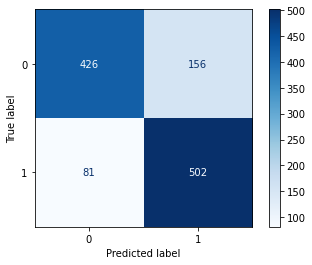

In [10]:
plot_confusion_matrix(nb_gs, X_test, y_test, cmap='Blues', values_format='d');

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, nb_preds))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       582
           1       0.76      0.86      0.81       583

    accuracy                           0.80      1165
   macro avg       0.80      0.80      0.80      1165
weighted avg       0.80      0.80      0.80      1165



In [12]:
f1_score(y_test, nb_preds)

0.8090249798549557

In [13]:
# Calculate the specificity
spec = tn / (tn + fp)
recall = recall_score(y_test, nb_preds)
sens = tp / (tp + fn)

print('Specificity:', spec)

Specificity: 0.7319587628865979


### Naive Bayes with TfidfVectorizer

In [19]:
nb2_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

nb2_pipe_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__max_features': [1_000, 1_500, 2_000, 2_500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [18]:
nb2_gs = GridSearchCV(nb2_pipe, 
                  param_grid=nb2_pipe_params, 
                  cv=5,
                  verbose=1,
                  n_jobs=6)

nb2_gs.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   20.0s
[Parallel(n_jobs=6)]: Done 320 out of 320 | elapsed:   36.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=6,
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [1000, 1500, 2000, 2500],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [16]:
metrics(nb2_gs)

Best Score: 0.7711015736766809

Best Params: {'tvec__max_df': 0.9, 'tvec__max_features': 1000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}

Train Score: 0.8188841201716738

Test Score: 0.7871244635193133


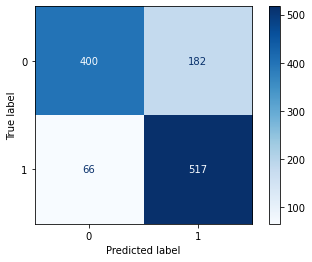

In [20]:
nb2_preds = nb2_gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, nb2_preds).ravel()
plot_confusion_matrix(nb2_gs, X_test, y_test, cmap='Blues', values_format='d');

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, nb2_preds))

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       582
           1       0.74      0.89      0.81       583

    accuracy                           0.79      1165
   macro avg       0.80      0.79      0.78      1165
weighted avg       0.80      0.79      0.78      1165



### Logistic Regression

In [38]:
lr=LogisticRegression()

lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

lr_pipe_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [1_000, 1_500, 2_000, 2_500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__max_iter': [5000]
}

lr_gs = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params, 
                  cv=5,
                  verbose=1,
                  n_jobs=6)

lr_gs.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   26.8s
[Parallel(n_jobs=6)]: Done 320 out of 320 | elapsed:   47.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 1500, 2000, 2500],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__max_iter': [5000]},
             verbose=1)

In [39]:
metrics(lr_gs)

Best Score: 0.8074391988555079

Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'lr__max_iter': 5000}

Train Score: 0.9547925608011445

Test Score: 0.8214592274678112


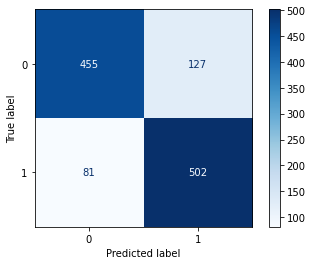

In [40]:
lr_preds = lr_gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, lr_preds).ravel()
plot_confusion_matrix(lr_gs, X_test, y_test, cmap='Blues', values_format='d');

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       582
           1       0.80      0.86      0.83       583

    accuracy                           0.82      1165
   macro avg       0.82      0.82      0.82      1165
weighted avg       0.82      0.82      0.82      1165



In [43]:
lr2=LogisticRegression()

lr2_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr2', LogisticRegression())
])

lr2_pipe_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__max_features': [1_000, 1_500, 2_000, 2_500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr2__max_iter': [5000]
}

lr2_gs = GridSearchCV(lr2_pipe, 
                  param_grid=lr2_pipe_params, 
                  cv=5,
                  verbose=1,
                  n_jobs=6)

lr2_gs.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   23.0s
[Parallel(n_jobs=6)]: Done 320 out of 320 | elapsed:   39.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr2', LogisticRegression())]),
             n_jobs=6,
             param_grid={'lr2__max_iter': [5000], 'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [1000, 1500, 2000, 2500],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [44]:
metrics(lr2_gs)

Best Score: 0.8277539341917024

Best Params: {'lr2__max_iter': 5000, 'tvec__max_df': 0.9, 'tvec__max_features': 2500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}

Train Score: 0.9055793991416309

Test Score: 0.8420600858369098


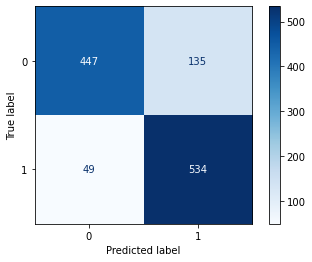

In [45]:
lr2_preds = lr2_gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, lr2_preds).ravel()
plot_confusion_matrix(lr2_gs, X_test, y_test, cmap='Blues', values_format='d');

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr2_preds))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       582
           1       0.80      0.92      0.85       583

    accuracy                           0.84      1165
   macro avg       0.85      0.84      0.84      1165
weighted avg       0.85      0.84      0.84      1165



### Random Forest

In [ ]:
X = df['selftext']
y = df['subreddit']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=77, stratify=y)

In [48]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

rf_pipe_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [1_000, 1_500, 2_000, 2_500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [75,125,150],
    'rf__max_features': ['auto'],
    'rf__max_depth': [3,4,5],
    'rf__min_samples_leaf': [3,4],
    'rf__ccp_alpha': [0.001,0.01]
}

rf_gs = GridSearchCV(rf_pipe, 
                  param_grid=rf_pipe_params, 
                  cv=5,
                 verbose=1,
                 n_jobs=6)

rf_gs.fit(X_train,y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   21.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   59.4s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 26.4min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 30.4mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 1500, 2000, 2500],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'rf__ccp_alpha': [0.001, 0.01],
                         'rf__max_depth': [3, 4, 5],
                         'rf__max_features': ['auto'],
                         'rf__min_samples_leaf': [3, 4],
                         'rf__n_estimators': [75, 125, 150]},
             verbose=1)

In [49]:
metrics(rf_gs)

Best Score: 0.8334763948497855

Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__ccp_alpha': 0.001, 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 3, 'rf__n_estimators': 75}

Train Score: 0.8389127324749642

Test Score: 0.8266094420600858


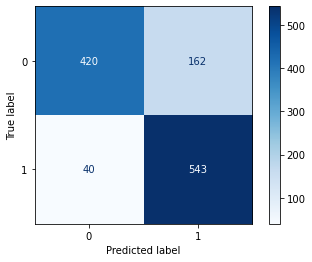

In [50]:
rf_preds = rf_gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()
plot_confusion_matrix(rf_gs, X_test, y_test, cmap='Blues', values_format='d');

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81       582
           1       0.77      0.93      0.84       583

    accuracy                           0.83      1165
   macro avg       0.84      0.83      0.82      1165
weighted avg       0.84      0.83      0.82      1165



In [53]:
rf2_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf2', RandomForestClassifier())
])

rf2_pipe_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__max_features': [1_000, 1_500, 2_000, 2_500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf2__n_estimators': [75,125,150],
    'rf2__max_features': ['auto'],
    'rf2__max_depth': [3,4,5],
    'rf2__min_samples_leaf': [3,4],
    'rf2__ccp_alpha': [0.001,0.01]
}

rf2_gs = GridSearchCV(rf2_pipe, 
                  param_grid=rf2_pipe_params, 
                  cv=5,
                 verbose=1,
                 n_jobs=6)

rf2_gs.fit(X_train,y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   27.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 28.3min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 32.8mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf2', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'rf2__ccp_alpha': [0.001, 0.01],
                         'rf2__max_depth': [3, 4, 5],
                         'rf2__max_features': ['auto'],
                         'rf2__min_samples_leaf': [3, 4],
                         'rf2__n_estimators': [75, 125, 150],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [1000, 1500, 2000, 2500],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [55]:
metrics(rf2_gs)

Best Score: 0.8320457796852647

Best Params: {'rf2__ccp_alpha': 0.001, 'rf2__max_depth': 5, 'rf2__max_features': 'auto', 'rf2__min_samples_leaf': 4, 'rf2__n_estimators': 150, 'tvec__max_df': 0.9, 'tvec__max_features': 2500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}

Train Score: 0.8457796852646638

Test Score: 0.8360515021459227


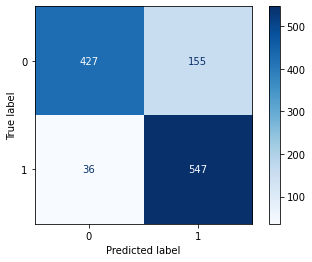

In [56]:
rf2_preds = rf2_gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, rf2_preds).ravel()
plot_confusion_matrix(rf2_gs, X_test, y_test, cmap='Blues', values_format='d');

In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf2_preds))

              precision    recall  f1-score   support

           0       0.92      0.73      0.82       582
           1       0.78      0.94      0.85       583

    accuracy                           0.84      1165
   macro avg       0.85      0.84      0.83      1165
weighted avg       0.85      0.84      0.83      1165



### Conclusion and Recommendations

It is a core business value to place customer centricity at the core of the business. In this project, I explored how Lyft can understand the customer voice through Natural Language Processing. In this case, a NLP Machine Learning model was created to predict whether text data came from the Lyft or Uber subreddit. I was able to achieve success with a logistic regression model with a TFID Vectorizer that classifies posts with 84% accuracy. This was a major improvement of the baseline model which had a 50% accuracy. Although the model was slightly overfit, the model had the highest test score of 0.84.

**Recommendations**  
Lyft can utilize this model to pull text data from other social media platforms in order to evaluate and collect service feedback in realtime. Further analysis of the sentiment polarity scores can be conducted in order to figure out the positive, negative, or neutral sentiments towards the brand. The sentiment analysis scores can also serve as a company wide metric as a basis for measuring customer satisfaction. The model provides leaders to drive better strategic decisions based on feedback from customers.

In order to improve upon the model, a larger pool of data can be collected and fed into the model. The model will learn from the greater set of data and provide more accurate predictions. Furthermore, the data can be cleaned deeply by stemming/lemmatizing each post. By simplifying the text data, the model can learn from a uniform data set and therefore provide better predictions.